In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-in-csv/mnist_test.csv
/kaggle/input/mnist-in-csv/mnist_train.csv


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


In [12]:
class CSVDataset(Dataset):
    def __init__(self, csv_file):
        df = pd.read_csv(csv_file)
        self.data = df[(df['label'] ==5) | (df['label'] ==6) | (df['label'] ==7) | (df['label'] ==0) | (df['label'] ==2)]
        self.X = self.data.iloc[:, 1:].values
        self.X = self.X.reshape(-1,1, 28, 28).astype(np.float32)/255
        label_map = {0: 0, 2: 1, 5: 2, 6: 3, 7: 4}
        self.y = self.data['label'].map(label_map).values
        #self.y = self.data.iloc[:, -1].values
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        y=torch.tensor(self.y[idx], dtype=torch.long)
        return x, y


In [13]:
train_dataset = CSVDataset('/kaggle/input/mnist-in-csv/mnist_train.csv')
test_dataset = CSVDataset('/kaggle/input/mnist-in-csv/mnist_test.csv')
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [15]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 30),
            nn.ReLU(),
            nn.Linear(30, 20),
        )

        self.decoder = nn.Sequential(
            nn.Linear(20, 30),
            nn.ReLU(),
            nn.Linear(30, 50),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Linear(100, 28*28),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1,1, 28, 28)
        return x
        

In [16]:
def model_training(model, criterion, optimizer, epochs=50):
    train_losses, test_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        total_train_loss = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            
            
        avg_train_loss = total_train_loss/len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()    
        total_test_loss = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, images)
                total_test_loss += loss.item()


        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {avg_train_loss:.4f} | "
                  f"Test Loss: {avg_test_loss:.4f}")

                
    return train_losses, test_losses
    


In [17]:
model = AutoEncoder().to(device)
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [18]:
train_losses, test_losses = model_training(model, criterion, optimizer, epochs=50)

Epoch 1/50 | Train Loss: 6509.2588 | Test Loss: 4993.1519
Epoch 2/50 | Train Loss: 4457.9852 | Test Loss: 4101.9508
Epoch 3/50 | Train Loss: 3947.1681 | Test Loss: 3857.5591
Epoch 4/50 | Train Loss: 3775.3230 | Test Loss: 3728.4485
Epoch 5/50 | Train Loss: 3682.2714 | Test Loss: 3654.4835
Epoch 6/50 | Train Loss: 3593.6979 | Test Loss: 3541.8430
Epoch 7/50 | Train Loss: 3490.1151 | Test Loss: 3450.6478
Epoch 8/50 | Train Loss: 3423.5264 | Test Loss: 3424.6800
Epoch 9/50 | Train Loss: 3377.5597 | Test Loss: 3366.4956
Epoch 10/50 | Train Loss: 3340.2354 | Test Loss: 3365.0055
Epoch 11/50 | Train Loss: 3306.6888 | Test Loss: 3302.9944
Epoch 12/50 | Train Loss: 3255.9044 | Test Loss: 3248.4006
Epoch 13/50 | Train Loss: 3200.5831 | Test Loss: 3195.6425
Epoch 14/50 | Train Loss: 3157.7291 | Test Loss: 3143.8543
Epoch 15/50 | Train Loss: 3110.6259 | Test Loss: 3089.8845
Epoch 16/50 | Train Loss: 3060.4331 | Test Loss: 3031.6192
Epoch 17/50 | Train Loss: 3016.8083 | Test Loss: 2999.5730
Epoch 

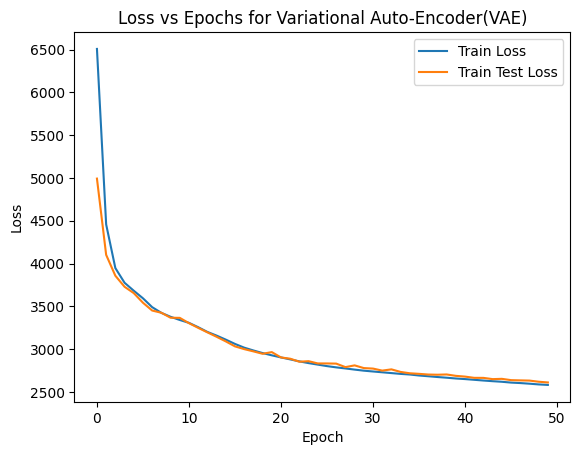

In [19]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Train Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs for Variational Auto-Encoder(VAE)")
plt.legend()
plt.show()

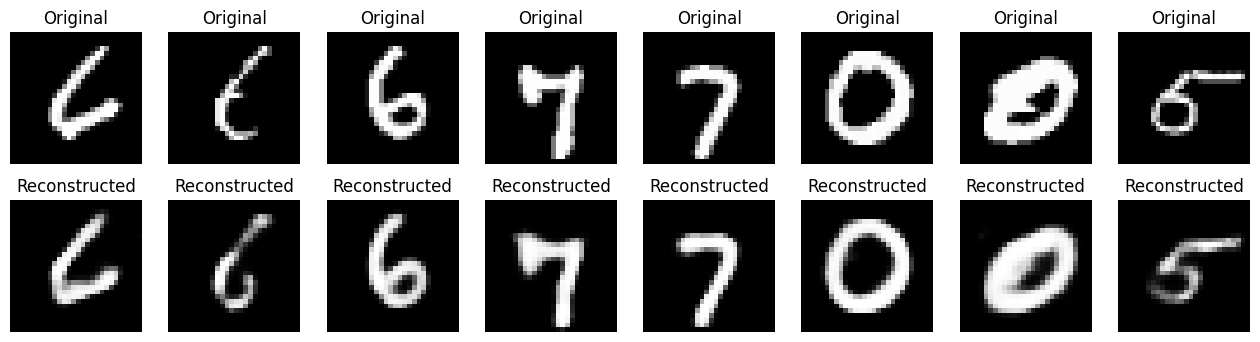

In [20]:

# Put model in evaluation mode
model.eval()

# Get a batch of test images (assuming you have test_loader)
dataiter = iter(test_loader)
images, _ = next(dataiter)
images = images.to(device)

# Pass through autoencoder
with torch.no_grad():
    outputs = model(images)

# Move to CPU and detach for plotting
images = images.cpu().numpy()
outputs = outputs.cpu().numpy()

# Plot original and reconstructed images side by side
n = 8  # number of images to show
plt.figure(figsize=(16, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i][0], cmap='gray')
    plt.title("Original")
    plt.axis("off")
    
    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(outputs[i][0], cmap='gray')
    plt.title("Reconstructed")
    plt.axis("off")
plt.show()
